In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rc, rcParams, style
#rcParams['text.usetex'] = True
#rc('font', **{'family': 'Times'})
#rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [3]:
dim = 2
X = ot.ComposedDistribution([ot.Uniform(0, 1)] * dim)

In [4]:
# OpenTURNS implementation of the main design of experiments methods
def regular_grid_sample(size):
    mesher = ot.IntervalMesher([int(np.round(np.sqrt(size)) - 1)] * 2)
    interval = ot.Interval([0] * 2, [1] * 2)
    mesh = mesher.build(interval)
    return mesh.getVertices()
    
def MonteCarlo_sample(distribution, size):
    return distribution.getSample(size)

def quasi_MonteCarlo_sample(distribution, size, sequence=ot.SobolSequence(dim)):
    sobol_experiment = ot.LowDiscrepancyExperiment(sequence, distribution, size, False)
    return sobol_experiment.generate()

def LHS_sample(distribution, size):
    LHS_experiment = ot.LHSExperiment(distribution, size, True, True)
    return LHS_experiment.generate()

def optimized_LHS_sample(distribution, size, metric):
    LHS_experiment = ot.LHSExperiment(distribution, size, True, True)
    SA_profile = ot.GeometricProfile(10., 0.95, 20000)
    LHS_optimization_algo = ot.SimulatedAnnealingLHS(LHS_experiment, metric, SA_profile)
    LHS_optimization_algo.generate()
    return LHS_optimization_algo.getResult().getOptimalDesign()

# Matplotlib scatter plot
def plot_and_save(sample, savefile=None, title=None, x0=0, x1=1):
    plt.figure(figsize=(4,4))
    plt.scatter(sample[:, x0], sample[:, x1], marker='.', label="$n={}$".format(sample.getSize()), color='k', alpha=0.6)
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(np.linspace(0, 1, 6))
    plt.grid(color="C7", alpha=0.3)
    plt.xlabel("$x_{}$".format(x0 + 1))
    plt.ylabel("$x_{}$".format(x1 + 1))
    plt.legend(bbox_to_anchor=(0.5, -0.16), loc='upper center', ncol=1)
    if title is not None:
        plt.title(title)
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)

In [5]:
sns.set_style("ticks",{'axes.grid':True})
def joint_plot(sample, alpha, color, bins=20, savefile=None, split=False, color2="C3"):
    df = pd.DataFrame(np.array(sample), columns=["$x_1$", "$x_2$"])
    if not split:
        g = sns.jointplot(data=df, x="$x_1$", y="$x_2$", height=4, marginal_ticks=False, 
                                marginal_kws=dict(bins=bins, stat="probability", alpha=0.6), 
                                marker=".", alpha=alpha, color=color,
                                label="$n={}$".format(sample.getSize())
                                )
        plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1)
    else:
        g = sns.jointplot(data=df, x="$x_1$", y="$x_2$", height=4, marginal_ticks=False, 
                                marginal_kws=dict(bins=bins, stat="probability", alpha=0.6), 
                                marker=".", alpha=alpha, color=color,
                                label="$n={}$".format(sample.getSize())
                                )
        sns.scatterplot(data=df[:(sample.getSize() // 2)], x="$x_1$", y="$x_2$", 
            marker=".", color=color2,
            label="$n={}$".format(sample.getSize() // 2)
                    )
        plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
    g.ax_joint.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
    g.ax_joint.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])

    if savefile is not None:
        plt.savefig(savefile, dpi=300, bbox_inches='tight')
    return g

In [6]:
N = 8
alpha = 0.6
bins = 4

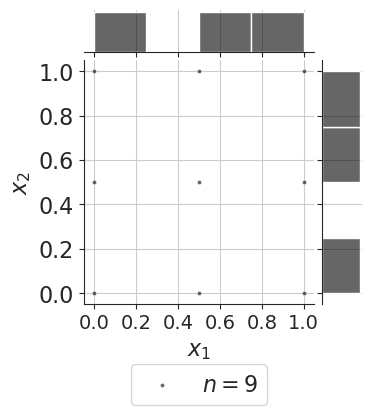

In [7]:
# regular grid sample
regular_sample = regular_grid_sample(N)
joint_plot(regular_sample, alpha, "k", bins, "figures/regular_grid.png");
#plot_and_save(regular_sample, "figures/regular_grid.png");

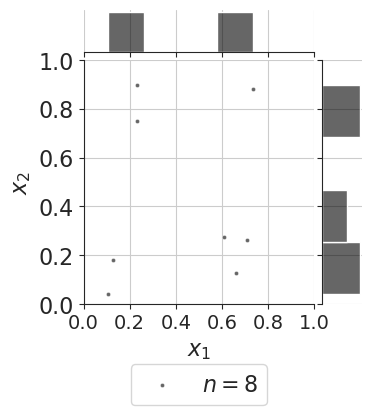

In [8]:
# crude Monte Carlo sample
ot.RandomGenerator.SetSeed(1)
cmc_sample = MonteCarlo_sample(X, N)
joint_plot(cmc_sample, alpha, "k", bins, "figures/monte_carlo.png");
#plot_and_save(cmc_sample, "figures/monte_carlo.png");

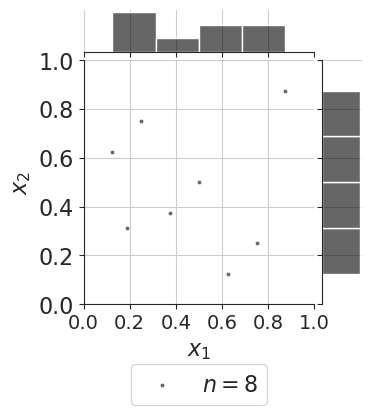

In [9]:
# Quasi Monte Carlo sample
qmc_sample = quasi_MonteCarlo_sample(X, N)
joint_plot(qmc_sample, alpha, "k", bins, "figures/quasi_monte_carlo.png");
#plot_and_save(qmc_sample, "figures/quasi_monte_carlo.png");

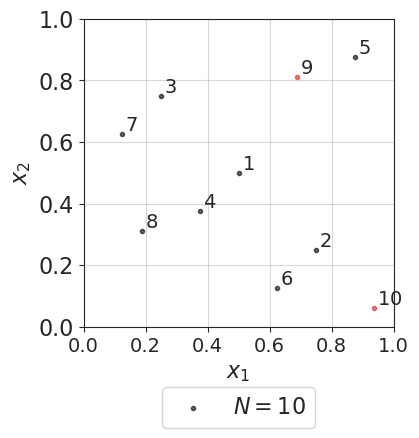

In [10]:
# Sequential qMC
qmc_sample = quasi_MonteCarlo_sample(X, N+2)
plt.figure(figsize=(4,4))
plt.scatter(qmc_sample[:N, 0], qmc_sample[:N, 1], marker='.', label="$N={}$".format(qmc_sample.getSize()), color='k', alpha=0.6)
plt.scatter(qmc_sample[N:, 0], qmc_sample[N:, 1], marker='.', color="C3", alpha=0.6)
for i in range(len(qmc_sample)):
    plt.text(qmc_sample[i][0]+0.01, qmc_sample[i][1]+0.01, "${}$".format(i + 1), weight="bold", fontsize=14)
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.grid(color="C7", alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(bbox_to_anchor=(0.5, -0.16), loc='upper center', ncol=1)
plt.savefig("figures/seq_quasi_monte_carlo.png", bbox_inches='tight', dpi=300);

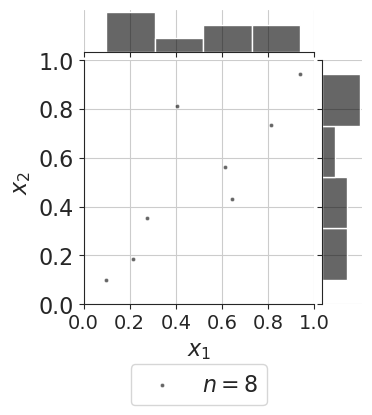

In [11]:
# LHS sample
# Poor LHS
ot.RandomGenerator.SetSeed(6)
lhs_sample = LHS_sample(X, N)
joint_plot(lhs_sample, alpha, "k", bins, "figures/poor_LHS.png");
#plot_and_save(lhs_sample, "figures/poor_LHS.png");

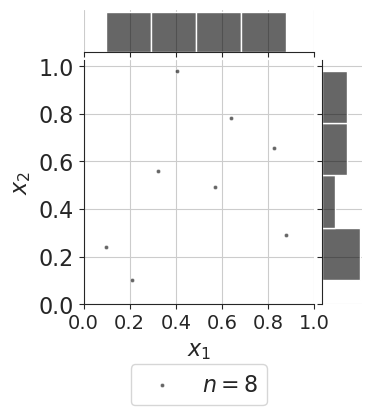

In [12]:
# LHS sample
# Good LHS
ot.RandomGenerator.SetSeed(4)
lhs_sample = LHS_sample(X, N)
joint_plot(lhs_sample, alpha, "k", bins, "figures/LHS.png");
#plot_and_save(lhs_sample, "figures/LHS.png");

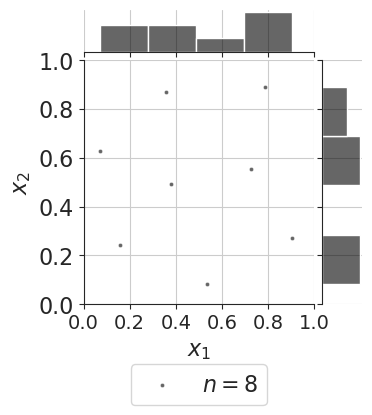

In [13]:
# Optimized LHS sample
# Different crterion implemented
# ot.SpaceFillingC2()
# ot.SpaceFillingPhiP()
# ot.SpaceFillingMinDist()
opt_lhs_sample = optimized_LHS_sample(X, N, ot.SpaceFillingMinDist())
joint_plot(opt_lhs_sample, alpha, "k", bins, "figures/optimized_mindist_LHS.png");
#plot_and_save(opt_lhs_sample, "figures/optimized_mindist_LHS.png");

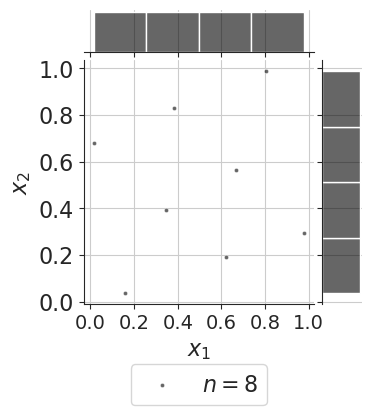

In [14]:
opt_lhs_sample = optimized_LHS_sample(X, N, ot.SpaceFillingPhiP())
joint_plot(opt_lhs_sample, alpha, "k", bins, "figures/optimized_phip_LHS.png");
#plot_and_save(opt_lhs_sample, "figures/optimized_phip_LHS.png");

## 2D : 64 & 256 points

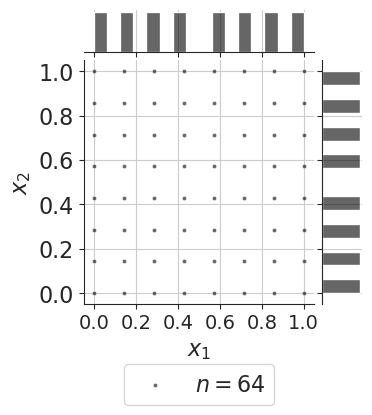

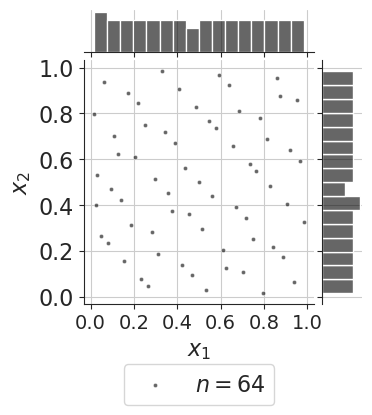

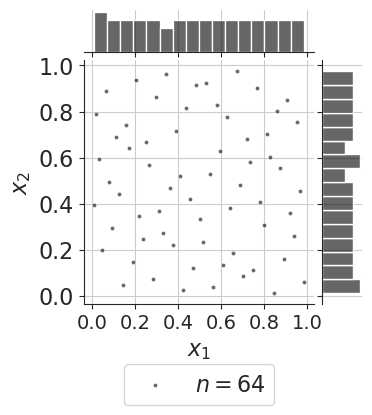

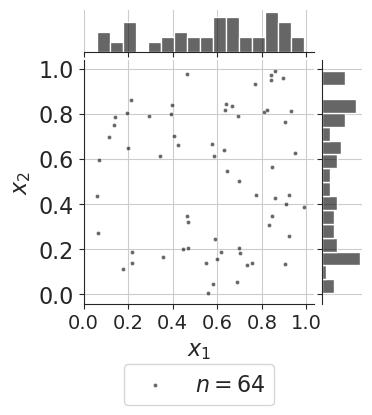

In [15]:
N = 64
bins = 16
# regular grid sample
regular_sample = regular_grid_sample(N)
joint_plot(regular_sample, alpha, "k", bins, "figures/regular_grid_{}.png".format(N));
#plot_and_save(regular_sample, "figures/regular_grid_{}.png".format(N), "Regular grid")

# Quasi Monte Carlo sample SOBOL
qmc_sample = quasi_MonteCarlo_sample(X, N)
joint_plot(qmc_sample, alpha, "k", bins, "figures/quasi_MonteCarlo_{}.png".format(N));
#plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_{}.png".format(N), "Sobol sequence")

# Quasi Monte Carlo sample HALTON
qmc_sample = quasi_MonteCarlo_sample(X, N, sequence=ot.HaltonSequence(dim))
joint_plot(qmc_sample, alpha, "k", bins, "figures/quasi_MonteCarlo_Halton_{}.png".format(N));
#plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_{}.png".format(N), "Sobol sequence")

# crude Monte Carlo sample
cmc_sample = MonteCarlo_sample(X, N)
joint_plot(cmc_sample, alpha, "k", bins, "figures/MonteCarlo{}.png".format(N));
#plot_and_save(cmc_sample, "figures/MonteCarlo{}.png".format(N), "Monte Carlo");

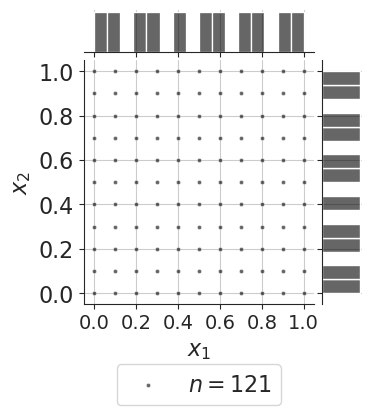

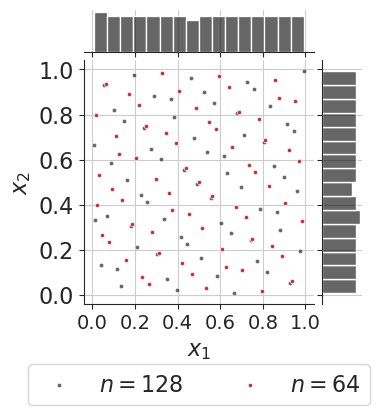

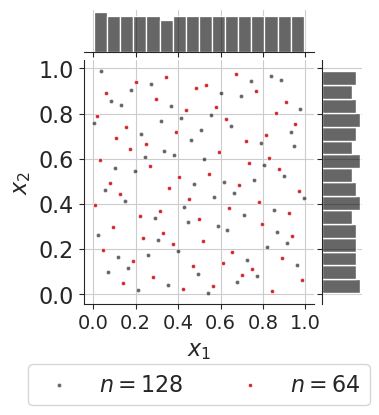

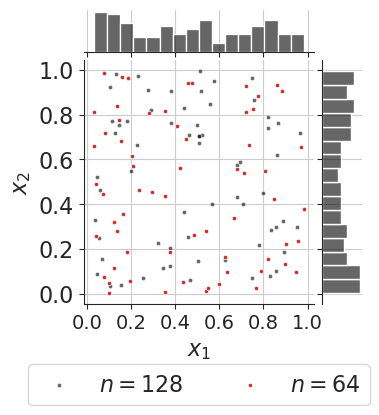

In [22]:
N = 128
bins = 16
# regular grid sample
regular_sample = regular_grid_sample(N)
joint_plot(regular_sample, alpha, "k", bins, "figures/regular_grid_{}.png".format(N));
#plot_and_save(regular_sample, "figures/regular_grid_{}.png".format(N), "Regular grid")

# Quasi Monte Carlo sample
qmc_sample = quasi_MonteCarlo_sample(X, N)
joint_plot(qmc_sample, alpha, "k", bins, "figures/quasi_MonteCarlo_{}.png".format(N), split=True);
#plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_{}.png".format(N), "Sobol sequence")

# Quasi Monte Carlo sample HALTON
qmc_sample = quasi_MonteCarlo_sample(X, N, sequence=ot.HaltonSequence(dim))
joint_plot(qmc_sample, alpha, "k", bins, "figures/quasi_MonteCarlo_Halton_{}.png".format(N), split=True);
#plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_{}.png".format(N), "Sobol sequence")

# crude Monte Carlo sample
cmc_sample = MonteCarlo_sample(X, N)
joint_plot(cmc_sample, alpha, "k", bins, "figures/MonteCarlo{}.png".format(N), split=True);
#plot_and_save(cmc_sample, "figures/MonteCarlo{}.png".format(N), "Monte Carlo");

## 8D qMC vs. scrambeled qMC

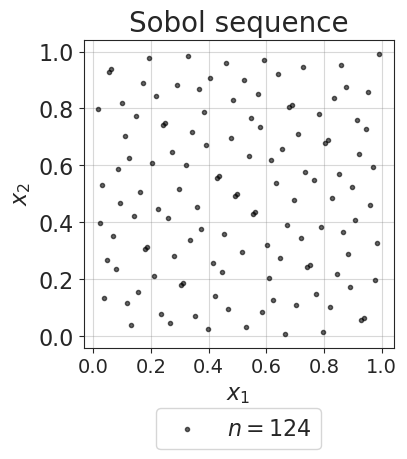

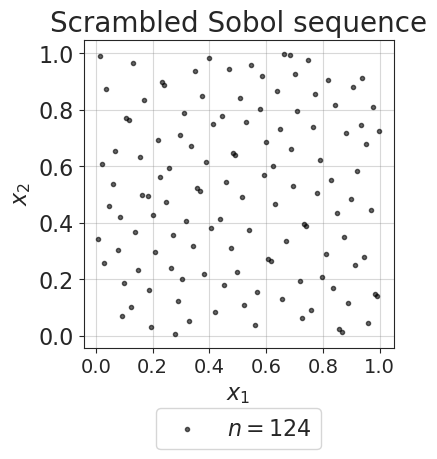

In [18]:
dim = 8
N = 124
sequence = ot.SobolSequence(dim)
sobol_experiment = ot.LowDiscrepancyExperiment(sequence, X, N, False)
qmc_sample =  sobol_experiment.generate()
plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_8D_{}.png".format(N), "Sobol sequence")
sobol_experiment.setRandomize(True)
qmc_sample =  sobol_experiment.generate()
plot_and_save(qmc_sample, "figures/scrambled_quasi_MonteCarlo_8D_{}.png".format(N), "Scrambled Sobol sequence")

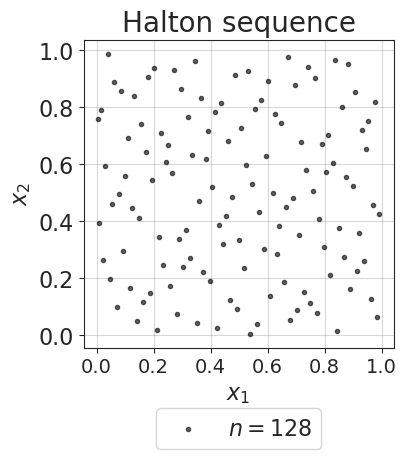

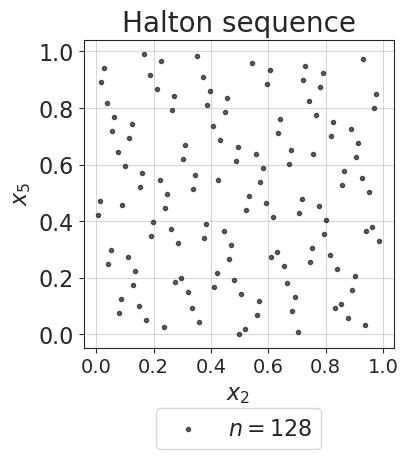

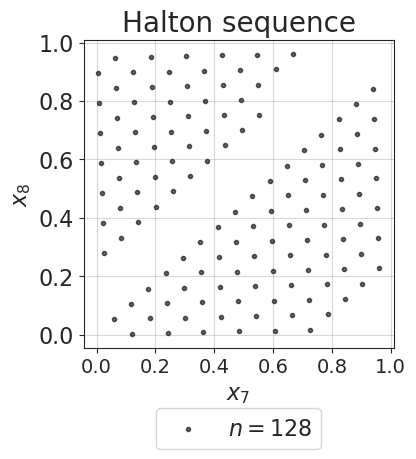

In [19]:
dim = 8
N = 128
sequence = ot.HaltonSequence(dim)
sobol_experiment = ot.LowDiscrepancyExperiment(sequence, ot.ComposedDistribution([ot.Uniform(0, 1)] * dim), N, False)
qmc_sample =  sobol_experiment.generate()
plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_8D_Halton_{}.png".format(N), "Halton sequence")
plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_8D_Halton_pathologic1_{}.png".format(N), "Halton sequence", 1, 4)
plot_and_save(qmc_sample, "figures/quasi_MonteCarlo_8D_Halton_pathologic2_{}.png".format(N), "Halton sequence", 6, 7)
